In [10]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

In [2]:
def load_data(data_dir, cache_on=True):
    def read_image(filename):
        label = int(filename[filename.rindex('_') + 1])
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        return img, label
    
    def read_images(img_dir):
        cache = os.path.join(img_dir, 'data.npz')
        if cache_on and os.path.exists(cache):
            with open(cache, 'rb') as f:
                data = np.load(f)
                return data['arr_0'], data['arr_1']

        X, y = [], []
        for filename in os.listdir(img_dir):
            if os.path.splitext(filename)[1] != '.png':
                continue
            img, label = read_image(os.path.join(img_dir, filename))
            X.append(img)
            y.append(label)

        X = np.array(X)
        y = np.array(y)
        
        if cache_on:
            np.savez(cache, X, y)

        return X, y
    
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')
    return read_images(train_dir), read_images(test_dir)

In [3]:
(Xtrain, ytrain), (Xtest, ytest) = load_data('images')

In [153]:
Counter(ytrain), Counter(ytest)

(Counter({1: 3000, 2: 3000, 3: 3000, 4: 3000, 0: 3000, 5: 3000}),
 Counter({4: 600, 1: 600, 2: 600, 0: 600, 5: 600, 3: 600}))

In [5]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(6, activation='softmax'),
])

In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=2)

Epoch 1/2
563/563 [==============================] - 19s 31ms/step - loss: 234.1844 - accuracy: 0.7482 - val_loss: 3.4980 - val_accuracy: 0.9625
Epoch 2/2
563/563 [==============================] - 17s 31ms/step - loss: 5.0245 - accuracy: 0.9628 - val_loss: 2.5792 - val_accuracy: 0.9800


In [12]:
df = pd.DataFrame(history.history)

<AxesSubplot:>

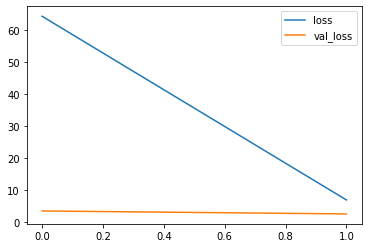

In [14]:
df[['loss', 'val_loss']].plot()

In [39]:
model.predict(np.expand_dims(Xtest[5], axis=0)).argmax()

1

In [36]:
model.save(os.path.join('models', 'dummy-model'))

INFO:tensorflow:Assets written to: models/dummy-model/assets


In [37]:
loaded = keras.models.load_model(os.path.join('models', 'dummy-model'))

In [40]:
loaded.predict(np.expand_dims(Xtest[5], axis=0)).argmax()

1

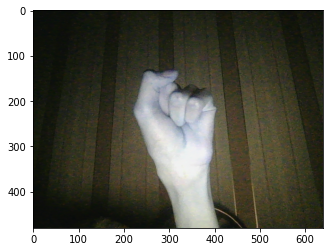

In [147]:
source = cv2.VideoCapture(0)
_, frame = source.read()
plt.imshow(frame)
source.release()

In [136]:
frame.shape

(480, 640, 3)

In [148]:
rframe = cv2.resize(frame, (128, 128))

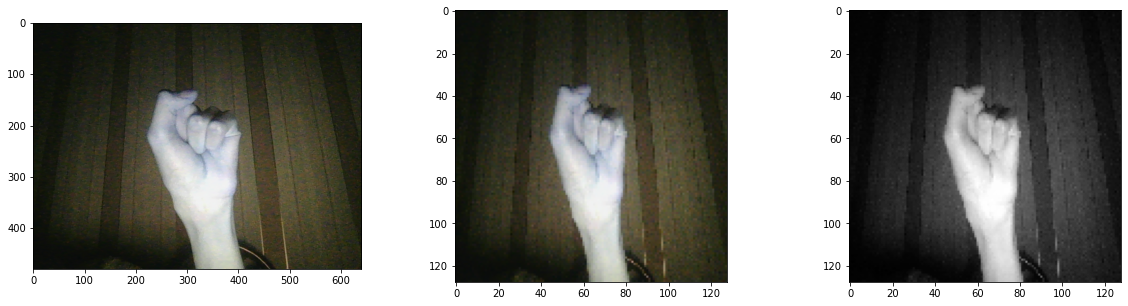

In [149]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(frame)

plt.subplot(1, 3, 2)
plt.imshow(rframe)

plt.subplot(1, 3, 3)
rgframe = cv2.cvtColor(rframe, cv2.COLOR_BGR2GRAY)
plt.imshow(rgframe, cmap='gray')

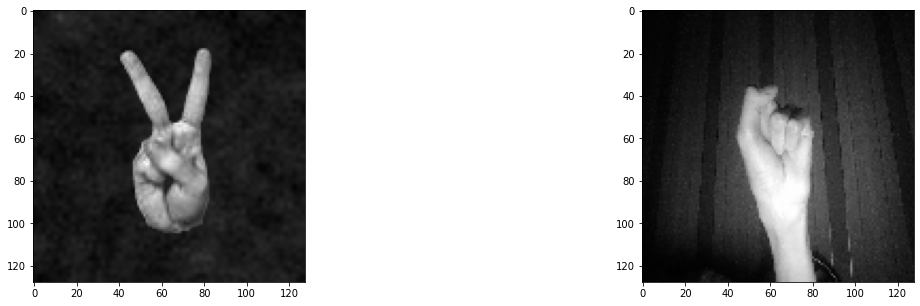

In [150]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.imshow(Xtrain[1], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(rgframe, cmap='gray')

In [152]:
model.predict(np.expand_dims(rgframe, axis=0))

array([[0., 0., 0., 0., 0., 1.]], dtype=float32)